In [1]:
import pandas as pd

In [2]:
# import matplotlib.pyplot as plt
import gensim
import numpy as np
import spacy

import os, re, operator, warnings

nlp = spacy.load("en")

import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION,p.OPT.RESERVED,p.OPT.SMILEY,p.OPT.NUMBER) # Setting paramenter to only remove the mentioned from the tweet
from unicodedata import normalize
import re
from nltk.tokenize import TweetTokenizer
import nltk
# nltk.download('stopwords')
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'


def words_tokenizer(data):
    tknzr = TweetTokenizer()
    words = tknzr.tokenize(data)
    return words

def preprocessing_pipeline(tweet,bigrams=True):
    tweet = p.clean(tweet) # Python tweet preprocessor to remove URL, Mention, Hashtag, Reserved Words, Emoji, Smiley
    tweet = tweet.lstrip("b'").rstrip("''") # Removing 'b' character and the single quotes from the tweet
    tweet = re.sub(r'\\\S+', '', tweet) # Replace all character starting with '\' till space
    tweet = re.sub(r'([^\w\s])|_+', ' ', tweet) # Removing punctuations
#     tweet = re.sub('['+my_punctuation + ']+', '', tweet) # strip punctuation
    tweet = re.sub(r'(\s\S{1,2}$)|(\s\S{1,2}\s$)','',tweet) # Removing the residual words at the end of the sentence with at most 2 characters
    tweet = re.sub(r'^\s','',tweet) # Removing whitespace from the start of the tweet
    tweet = re.sub(r'\s$','',tweet) # Removing whitespace from the end of the tweet
    tweet = re.sub(r'\s\s+',' ',tweet) # Removing extra space throughout
    tweet = tweet.lower() # Lower-casing the text
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] # remove stopwords

#     tweet_token_list = [word_rooter(word) if '#' not in word else word
#                         for word in tweet_token_list] # apply word rooter
#     if bigrams:
#         tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
#                                             for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

def spacy_prepro(doc):
    # we add some words to the stop word list
    article = []
    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article!
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and w.text!=' ' and w.text not in article:
            # we add the lematized version of the word
            article.append(w.lemma_)
    return article



In [3]:
filepath = 'LIAR-PLUS/dataset/train2.tsv'
filepath_test = 'LIAR-PLUS/dataset/test2.tsv'
filepath_val = 'LIAR-PLUS/dataset/val2.tsv'

In [4]:
df = pd.read_csv(filepath, usecols=[2,3,9,10,11,12,13,15], names=['label', 'statement','barely_true_count','false_count','half_true_count','mostly_true_count','pof_count','justification'], header=None, delimiter='\t')
df_test = pd.read_csv(filepath_test, usecols=[2,3,9,10,11,12,13,15], names=['label', 'statement','barely_true_count','false_count','half_true_count','mostly_true_count','pof_count','justification'], header=None, delimiter='\t')
df_val = pd.read_csv(filepath_val, usecols=[2,3,9,10,11,12,13,15], names=['label', 'statement','barely_true_count','false_count','half_true_count','mostly_true_count','pof_count','justification'], header=None, delimiter='\t')

In [5]:
true_labels = ['half-true', 'mostly true', 'true']
false_labels = ['pants on fire', 'false', 'mostly false']

train_labels_multi = df['label']
train_labels_binary = []
for i in range(len(train_labels_multi)):
    if train_labels_multi[i] in true_labels:
        train_labels_binary.append('true')
    else:
        train_labels_binary.append('false')
        
test_labels_multi = df_test['label']
test_labels_binary = []
for i in range(len(test_labels_multi)):
    if test_labels_multi[i] in true_labels:
        test_labels_binary.append('true')
    else:
        test_labels_binary.append('false')

val_labels_multi = df_val['label']
val_labels_binary = []
for i in range(len(val_labels_multi)):
    if val_labels_multi[i] in true_labels:
        val_labels_binary.append('true')
    else:
        val_labels_binary.append('false')

In [6]:
train_blabels_df = pd.DataFrame(train_labels_binary)
train_blabels_df.columns = ["label"]

test_blabels_df = pd.DataFrame(test_labels_binary)
test_blabels_df.columns = ["label"]

val_blabels_df = pd.DataFrame(val_labels_binary)
val_blabels_df.columns = ["label"]

# S Dataset

In [7]:
from tqdm import tqdm

In [8]:
train_processed_S = []
for i in tqdm(range(len(df['statement']))):
    a = preprocessing_pipeline(df['statement'][i])
    b = ' '.join(spacy_prepro(nlp(a)))
    train_processed_S.append(b)

100%|██████████| 10240/10240 [01:25<00:00, 120.22it/s]


In [9]:
test_processed_S = []
for i in tqdm(range(len(df_test['statement']))):
    a = preprocessing_pipeline(df_test['statement'][i])
    b = ' '.join(spacy_prepro(nlp(a)))
    test_processed_S.append(b)

100%|██████████| 1267/1267 [00:09<00:00, 134.21it/s]


In [10]:
val_processed_S = []
for i in tqdm(range(len(df_val['statement']))):
    a = preprocessing_pipeline(df_val['statement'][i])
    b = ' '.join(spacy_prepro(nlp(a)))
    val_processed_S.append(b)

100%|██████████| 1284/1284 [00:09<00:00, 133.21it/s]


# SVM

## Binary Classification

> Validation coming better on unigram, test better on TFIDF

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
# vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,preprocessor = None,min_df = 2, ngram_range=(1,2)) # ngram_range = unigram and bigrams
vectorizer = CountVectorizer()

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer

X_train_S = vectorizer.fit_transform(train_processed_S)
# tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_S) 
# X_train_S = tf_transformer.transform(X_train_S)

X_test_S = vectorizer.transform(test_processed_S)
# tf_transformer = TfidfTransformer(use_idf=True).fit(X_test_S) 
# X_test_S = tf_transformer.transform(X_test_S)

X_val_S = vectorizer.transform(val_processed_S)
# tf_transformer = TfidfTransformer(use_idf=True).fit(X_val_S) 
# X_val_S = tf_transformer.transform(X_val_S)

In [13]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
model = LinearSVC(random_state=0, tol=1e-5)
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
# clf = GridSearchCV(model, parameters, cv=5)
model.fit(X_train_S,train_blabels_df['label'])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [14]:
# test set
predicted =model.predict(X_test_S)

In [15]:
print(classification_report(test_blabels_df['label'], predicted))
count=0
for i in range(len(test_blabels_df['label'])):
    if test_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.5659037095501184


In [16]:
# validation set
predicted_val_S =model.predict(X_val_S)

In [17]:
print(classification_report(val_blabels_df['label'], predicted))
count=0
for i in range(len(val_blabels_df['label'])):
    if val_blabels_df['label'][i]==predicted_val_S[i]:
        count+=1
print(count/len(predicted_val_S))

0.6160436137071651


## Multi-class Classification

> Giving better results on unigram model

In [29]:
X_train_S = vectorizer.fit_transform(train_processed_S)
# tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_S) 
# X_train_S = tf_transformer.transform(X_train_S)

X_test_S = vectorizer.transform(test_processed_S)
# tf_transformer = TfidfTransformer(use_idf=True).fit(X_test_S) 
# X_test_S = tf_transformer.transform(X_test_S)

X_val_S = vectorizer.transform(val_processed_S)
# tf_transformer = TfidfTransformer(use_idf=True).fit(X_val_S) 
# X_val_S = tf_transformer.transform(X_val_S)

In [30]:
model = LinearSVC(random_state=0, tol=1e-5)
model.fit(X_train_S,df['label'])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [31]:
# test set

predicted =model.predict(X_test_S)
print(classification_report(df_test['label'], predicted))
count=0
for i in range(len(df_test['label'])):
    if df_test['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.23046566692975531


In [32]:
# validation set

predicted_val_S =model.predict(X_val_S)
print(classification_report(df_val['label'], predicted))
count=0
for i in range(len(df_val['label'])):
    if df_val['label'][i]==predicted_val_S[i]:
        count+=1
print(count/len(predicted_val_S))

0.2398753894080997


In [ ]:
# ### Combining train and validation

# train_val_processed_S = train_processed_S + val_processed_S
# a = list(df['label'])
# b = list(df_val['label'])
# c = np.array(a+b)

# X_train_val_S = vectorizer.fit_transform(train_val_processed_S)
# tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_val_S) 
# X_train_val_S = tf_transformer.transform(X_train_val_S)

# X_test_S = vectorizer.transform(test_processed_S)
# tf_transformer = TfidfTransformer(use_idf=True).fit(X_test_S) 
# X_test_S = tf_transformer.transform(X_test_S)

# model = LinearSVC(random_state=0, tol=1e-5)
# model.fit(X_train_val_S,c)

# count=0
# for i in range(len(df_test['label'])):
#     if df_test['label'][i]==predicted[i]:
#         count+=1
# print(count/len(predicted))

## Logistic Regression 

In [26]:
## Binary Classification

In [27]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='ovr').fit(X_train_S, train_blabels_df['label'])

/home/shreyash15097/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [33]:
predicted =clf.predict(X_test_S)
print(classification_report(test_blabels_df['label'], predicted))
count=0
for i in range(len(test_blabels_df['label'])):
    if test_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.5911602209944752


In [34]:
predicted_val_S =clf.predict(X_val_S)
print(classification_report(val_blabels_df['label'], predicted))
count=0
for i in range(len(val_blabels_df['label'])):
    if val_blabels_df['label'][i]==predicted_val_S[i]:
        count+=1
print(count/len(predicted_val_S))

0.6347352024922118


## Multi Classification

In [35]:
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train_S, df['label'])

/home/shreyash15097/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [36]:
predicted =clf.predict(X_test_S)
print(classification_report(df_test['label'], predicted))
count=0
for i in range(len(df_test['label'])):
    if df_test['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.23362273086029992


In [37]:
predicted_val_S =clf.predict(X_val_S)
print(classification_report(df_val['label'], predicted))
count=0
for i in range(len(df_val['label'])):
    if df_val['label'][i]==predicted_val_S[i]:
        count+=1
print(count/len(predicted_val_S))

0.2383177570093458


# SJ dataset

In [38]:
train_processed_J = []
for i in tqdm(range(len(df['justification']))):
    try:
        a = preprocessing_pipeline(df['justification'][i])
        b = ' '.join(spacy_prepro(nlp(a)))
        train_processed_J.append(b)
    except:
        train_processed_J.append("")

100%|██████████| 10240/10240 [02:03<00:00, 82.95it/s]


In [39]:
test_processed_J = []
for i in tqdm(range(len(df_test['justification']))):
    try:
        a = preprocessing_pipeline(df_test['justification'][i])
        b = ' '.join(spacy_prepro(nlp(a)))
        test_processed_J.append(b)
    except:
        test_processed_J.append("")

100%|██████████| 1267/1267 [00:15<00:00, 82.09it/s]


In [40]:
val_processed_J = []
for i in tqdm(range(len(df_val['justification']))):
    try:
        a = preprocessing_pipeline(df_val['justification'][i])
        b = ' '.join(spacy_prepro(nlp(a)))
        val_processed_J.append(b)
    except:
        val_processed_J.append("")

100%|██████████| 1284/1284 [00:15<00:00, 84.76it/s]


In [41]:
train_processed_SJ = []
for i in range(len(train_processed_S)):
    temp = train_processed_S[i]+" "+train_processed_J[i]
    train_processed_SJ.append(temp)

In [42]:
test_processed_SJ = []
for i in range(len(test_processed_S)):
    temp = test_processed_S[i]+" "+test_processed_J[i]
    test_processed_SJ.append(temp)

In [43]:
val_processed_SJ = []
for i in range(len(val_processed_S)):
    temp = val_processed_S[i]+" "+val_processed_J[i]
    val_processed_SJ.append(temp)

## Binary Classification

SVM

In [44]:
vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,preprocessor = None,min_df = 2, ngram_range=(1,2)) # ngram_range = unigram and bigrams
# vectorizer = CountVectorizer()

X_train_SJ = vectorizer.fit_transform(train_processed_SJ)
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_SJ) 
X_train_SJ = tf_transformer.transform(X_train_SJ)

X_test_SJ = vectorizer.transform(test_processed_SJ)
tf_transformer = TfidfTransformer(use_idf=True).fit(X_test_SJ) 
X_test_SJ = tf_transformer.transform(X_test_SJ)

X_val_SJ = vectorizer.transform(val_processed_SJ)
tf_transformer = TfidfTransformer(use_idf=True).fit(X_val_SJ) 
X_val_SJ = tf_transformer.transform(X_val_SJ)

In [45]:
model_LSVC = LinearSVC(random_state=0, tol=1e-5)
model_LSVC.fit(X_train_SJ,train_blabels_df['label'])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [46]:
predicted =model_LSVC.predict(X_test_SJ)
print(classification_report(test_blabels_df['label'], predicted))
count=0
for i in range(len(test_blabels_df['label'])):
    if test_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.5808997632202052


In [47]:
predicted =model_LSVC.predict(X_val_SJ)
print(classification_report(val_blabels_df['label'], predicted))
count=0
for i in range(len(val_blabels_df['label'])):
#     print(df_val['label'][i],predicted[i])
    if val_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.6105919003115264


Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='ovr').fit(X_train_SJ, train_blabels_df['label'])
# clf = LogisticRegression().fit(X,df['label'])

In [49]:
predicted =clf.predict(X_test_SJ)
print(classification_report(test_blabels_df['label'], predicted))
count=0
for i in range(len(test_blabels_df['label'])):
    if test_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.6235201262825573


In [50]:
predicted =clf.predict(X_val_SJ)
print(classification_report(val_blabels_df['label'], predicted))
count=0
for i in range(len(val_blabels_df['label'])):
    if val_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.6651090342679128


## Multi Classification

SVM

In [51]:
vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,preprocessor = None,min_df = 2, ngram_range=(1,2)) # ngram_range = unigram and bigrams
# vectorizer = CountVectorizer()

X_train_SJ = vectorizer.fit_transform(train_processed_SJ)
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_SJ) 
X_train_SJ = tf_transformer.transform(X_train_SJ)

X_test_SJ = vectorizer.transform(test_processed_SJ)
tf_transformer = TfidfTransformer(use_idf=True).fit(X_test_SJ) 
X_test_SJ = tf_transformer.transform(X_test_SJ)

X_val_SJ = vectorizer.transform(val_processed_SJ)
tf_transformer = TfidfTransformer(use_idf=True).fit(X_val_SJ) 
X_val_SJ = tf_transformer.transform(X_val_SJ)

In [52]:
model_LSVC = LinearSVC(random_state=0, tol=1e-5)
model_LSVC.fit(X_train_SJ,df['label'])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [53]:
predicted =model_LSVC.predict(X_test_SJ)
print(classification_report(df_test['label'], predicted))
count=0
for i in range(len(df_test['label'])):
    if df_test['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.21783741120757696


In [54]:
predicted =model_LSVC.predict(X_val_SJ)
print(classification_report(df_val['label'], predicted))
count=0
for i in range(len(df_val['label'])):
#     print(df_val['label'][i],predicted[i])
    if df_val['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.21339563862928349


Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train_SJ, df['label'])
# clf = LogisticRegression().fit(X,df['label'])

/home/shreyash15097/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [56]:
predicted =clf.predict(X_test_SJ)
print(classification_report(df_test['label'], predicted))
count=0
for i in range(len(df_test['label'])):
    if df_test['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.23441199684293607


In [57]:
predicted =clf.predict(X_val_SJ)
print(classification_report(df_val['label'], predicted))
count=0
for i in range(len(df_val['label'])):
    if df_val['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.24221183800623053


# S+M and S+MJ

> Only the vectorizer valued is changed for M and MJ dataset, rest remains same

## Sentiment

> Senti Strength with binary positivity and negativity labels

In [58]:
# from sentistrength import PySentiStr

# senti = PySentiStr()

In [59]:
# senti.setSentiStrengthPath('/home/shreyash15097/my/SentiStrength/SentiStrength.jar')
# senti.setSentiStrengthLanguageFolderPath('/home/shreyash15097/my/SentiStrength/SentiStrengthData/')

In [60]:
# train_senti = []
# for i in tqdm(range(len(train_processed_S))):
#     result = senti.getSentiment(train_processed_S[i], score='binary')
#     train_senti.append(result)

In [61]:
# test_senti = []
# for i in tqdm(range(len(test_processed_S))):
#     result = senti.getSentiment(test_processed_S[i], score='binary')
#     test_senti.append(result)

In [62]:
# val_senti = []
# for i in tqdm(range(len(df_val['statement']))):
#     result = senti.getSentiment(df_val['statement'][i], score='binary')
#     val_senti.append(result)

In [63]:
import pickle

senti_train = {}
with open('train_senti.pkl','rb') as f:
    senti_train = pickle.load(f)

senti_test = {}
with open('test_senti.pkl','rb') as f:
    senti_test = pickle.load(f)

senti_val = {}
with open('val_senti.pkl','rb') as f:
    senti_val = pickle.load(f)

Converting to pandas dataframe

In [64]:
pos_sent = []
neg_sent = []
for i in range(len(senti_train)):
    ps = senti_train[i][0][0]
    ns = senti_train[i][0][1]
    pos_sent.append(ps)
    neg_sent.append(abs(ns))
senti_train_df = pd.DataFrame(pos_sent,columns =['pos_sent']) 
senti_train_df['neg_sent'] = neg_sent

In [65]:
pos_sent = []
neg_sent = []
for i in range(len(senti_test)):
    ps = senti_test[i][0][0]
    ns = senti_test[i][0][1]
    pos_sent.append(ps)
    neg_sent.append(abs(ns))
senti_test_df = pd.DataFrame(pos_sent,columns =['pos_sent']) 
senti_test_df['neg_sent'] = neg_sent

In [66]:
pos_sent = []
neg_sent = []
for i in range(len(senti_val)):
    ps = senti_val[i][0][0]
    ns = senti_val[i][0][1]
    pos_sent.append(ps)
    neg_sent.append(abs(ns))
senti_val_df = pd.DataFrame(pos_sent,columns =['pos_sent']) 
senti_val_df['neg_sent'] = neg_sent

## Emotion Lexicon

In [67]:
df_lexicon = pd.read_csv('/home/shreyash15097/fnd/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', usecols=[0,1,2], names=['word','emotion','value'], header=None, delimiter='\t')

In [68]:
emolex_dic = {}
for i in range(len(df_lexicon)):
    word = df_lexicon['word'][i]
    emotion = df_lexicon['emotion'][i]
    value = df_lexicon['value'][i]
    if word not in emolex_dic:
        emolex_dic[word] = {}
    emolex_dic[word][emotion] = value

In [69]:
emolex_train = []
for i in range(len(df['statement'])):
    temp = df['statement'][i].lower().split()
    temp2 = np.zeros(10,dtype=int)
    for j in range(len(temp)):
        if temp[j] in emolex_dic:
            temp2 += np.array(list(emolex_dic[temp[j]].values()))
    emolex_train.append(list(temp2))

In [70]:
emolex_test = []
for i in range(len(df_test['statement'])):
    temp = df_test['statement'][i].lower().split()
    temp2 = np.zeros(10,dtype=int)
    for j in range(len(temp)):
        if temp[j] in emolex_dic:
            temp2 += np.array(list(emolex_dic[temp[j]].values()))
    emolex_test.append(temp2)

In [71]:
emolex_val = []
for i in range(len(df_val['statement'])):
    temp = df_val['statement'][i].lower().split()
    temp2 = np.zeros(10,dtype=int)
    for j in range(len(temp)):
        if temp[j] in emolex_dic:
            temp2 += np.array(list(emolex_dic[temp[j]].values()))
    emolex_val.append(temp2)

In [72]:
emolex_train_df = pd.DataFrame(emolex_train)
emolex_train_df.columns = ["e1", "e2", "e3", "e4", "e5", "e6", "e7", "e8", "e9", "e10"]

In [73]:
emolex_test_df = pd.DataFrame(emolex_test)
emolex_test_df.columns = ["e1", "e2", "e3", "e4", "e5", "e6", "e7", "e8", "e9", "e10"]

In [74]:
emolex_val_df = pd.DataFrame(emolex_val)
emolex_val_df.columns = ["e1", "e2", "e3", "e4", "e5", "e6", "e7", "e8", "e9", "e10"]

# Metadata

> That can be directly used from the original dataframes

In [75]:
df.keys()

Index(['label', 'statement', 'barely_true_count', 'false_count',
       'half_true_count', 'mostly_true_count', 'pof_count', 'justification'],
      dtype='object')

In [76]:
## Fixing nan values

In [77]:
df['barely_true_count'][2142] = 0.0
df['false_count'][2142] = 0.0
df['half_true_count'][2142] = 0.0
df['mostly_true_count'][2142] = 0.0
df['pof_count'][2142] = 0.0

/home/shreyash15097/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/shreyash15097/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/shreyash15097/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doi

In [78]:
df['barely_true_count'][9375] = 0.0
df['false_count'][9375] = 0.0
df['half_true_count'][9375] = 0.0
df['mostly_true_count'][9375] = 0.0
df['pof_count'][9375] = 0.0

/home/shreyash15097/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/shreyash15097/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/shreyash15097/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doi

In [79]:
# truenan = np.isnan(df['pof_count'])

In [80]:
# for i in range(len(truenan)):
#     if truenan[i]==True:
#         print(i)

## Combining features

## S+MJ

In [81]:
from scipy.sparse import hstack 
vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,preprocessor = None,min_df = 2, ngram_range=(1,2)) # ngram_range = unigram and bigrams
# vectorizer = CountVectorizer()

Train data

In [82]:
X_train_SpMJ = vectorizer.fit_transform(train_processed_SJ)
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_SpMJ) 
X_train_SpMJ = tf_transformer.transform(X_train_SpMJ)

In [83]:
#Adding rest of the features

# Sentiment Features
X_train_SpMJ = hstack((X_train_SpMJ,np.array(senti_train_df['pos_sent'])[:,None]))
X_train_SpMJ = hstack((X_train_SpMJ,np.array(senti_train_df['neg_sent'])[:,None]))

# Emolex features
X_train_SpMJ = hstack((X_train_SpMJ,np.array(emolex_train_df['e1'])[:,None]))
X_train_SpMJ = hstack((X_train_SpMJ,np.array(emolex_train_df['e2'])[:,None]))
X_train_SpMJ = hstack((X_train_SpMJ,np.array(emolex_train_df['e3'])[:,None]))
X_train_SpMJ = hstack((X_train_SpMJ,np.array(emolex_train_df['e4'])[:,None]))
X_train_SpMJ = hstack((X_train_SpMJ,np.array(emolex_train_df['e5'])[:,None]))
X_train_SpMJ = hstack((X_train_SpMJ,np.array(emolex_train_df['e6'])[:,None]))
X_train_SpMJ = hstack((X_train_SpMJ,np.array(emolex_train_df['e7'])[:,None]))
X_train_SpMJ = hstack((X_train_SpMJ,np.array(emolex_train_df['e8'])[:,None]))
X_train_SpMJ = hstack((X_train_SpMJ,np.array(emolex_train_df['e9'])[:,None]))
X_train_SpMJ = hstack((X_train_SpMJ,np.array(emolex_train_df['e10'])[:,None]))

# Metadata
X_train_SpMJ = hstack((X_train_SpMJ,np.array(df['barely_true_count'])[:,None]))
X_train_SpMJ = hstack((X_train_SpMJ,np.array(df['false_count'])[:,None]))
X_train_SpMJ = hstack((X_train_SpMJ,np.array(df['half_true_count'])[:,None]))
X_train_SpMJ = hstack((X_train_SpMJ,np.array(df['mostly_true_count'])[:,None]))
X_train_SpMJ = hstack((X_train_SpMJ,np.array(df['pof_count'])[:,None]))
print(np.isnan(X_train_SpMJ.data).any())


False


In [84]:
X_train_SpMJ.shape

(10240, 62415)

Test data

In [85]:
X_test_SpMJ = vectorizer.transform(test_processed_SJ)
tf_transformer = TfidfTransformer(use_idf=True).fit(X_test_SpMJ) 
X_test_SpMJ = tf_transformer.transform(X_test_SpMJ)

In [86]:
#Adding rest of the features

# Sentiment Features
X_test_SpMJ = hstack((X_test_SpMJ,np.array(senti_test_df['pos_sent'])[:,None]))
X_test_SpMJ = hstack((X_test_SpMJ,np.array(senti_test_df['neg_sent'])[:,None]))

# Emolex features
X_test_SpMJ = hstack((X_test_SpMJ,np.array(emolex_test_df['e1'])[:,None]))
X_test_SpMJ = hstack((X_test_SpMJ,np.array(emolex_test_df['e2'])[:,None]))
X_test_SpMJ = hstack((X_test_SpMJ,np.array(emolex_test_df['e3'])[:,None]))
X_test_SpMJ = hstack((X_test_SpMJ,np.array(emolex_test_df['e4'])[:,None]))
X_test_SpMJ = hstack((X_test_SpMJ,np.array(emolex_test_df['e5'])[:,None]))
X_test_SpMJ = hstack((X_test_SpMJ,np.array(emolex_test_df['e6'])[:,None]))
X_test_SpMJ = hstack((X_test_SpMJ,np.array(emolex_test_df['e7'])[:,None]))
X_test_SpMJ = hstack((X_test_SpMJ,np.array(emolex_test_df['e8'])[:,None]))
X_test_SpMJ = hstack((X_test_SpMJ,np.array(emolex_test_df['e9'])[:,None]))
X_test_SpMJ = hstack((X_test_SpMJ,np.array(emolex_test_df['e10'])[:,None]))

# Metadata
X_test_SpMJ = hstack((X_test_SpMJ,np.array(df_test['barely_true_count'])[:,None]))
X_test_SpMJ = hstack((X_test_SpMJ,np.array(df_test['false_count'])[:,None]))
X_test_SpMJ = hstack((X_test_SpMJ,np.array(df_test['half_true_count'])[:,None]))
X_test_SpMJ = hstack((X_test_SpMJ,np.array(df_test['mostly_true_count'])[:,None]))
X_test_SpMJ = hstack((X_test_SpMJ,np.array(df_test['pof_count'])[:,None]))

In [87]:
X_test_SpMJ.shape

(1267, 62415)

Validation data

In [88]:
X_val_SpMJ = vectorizer.transform(val_processed_SJ)
tf_transformer = TfidfTransformer(use_idf=True).fit(X_val_SpMJ) 
X_val_SpMJ = tf_transformer.transform(X_val_SpMJ)

In [89]:
#Adding rest of the features

# Sentiment Features
X_val_SpMJ = hstack((X_val_SpMJ,np.array(senti_val_df['pos_sent'])[:,None]))
X_val_SpMJ = hstack((X_val_SpMJ,np.array(senti_val_df['neg_sent'])[:,None]))

# Emolex features
X_val_SpMJ = hstack((X_val_SpMJ,np.array(emolex_val_df['e1'])[:,None]))
X_val_SpMJ = hstack((X_val_SpMJ,np.array(emolex_val_df['e2'])[:,None]))
X_val_SpMJ = hstack((X_val_SpMJ,np.array(emolex_val_df['e3'])[:,None]))
X_val_SpMJ = hstack((X_val_SpMJ,np.array(emolex_val_df['e4'])[:,None]))
X_val_SpMJ = hstack((X_val_SpMJ,np.array(emolex_val_df['e5'])[:,None]))
X_val_SpMJ = hstack((X_val_SpMJ,np.array(emolex_val_df['e6'])[:,None]))
X_val_SpMJ = hstack((X_val_SpMJ,np.array(emolex_val_df['e7'])[:,None]))
X_val_SpMJ = hstack((X_val_SpMJ,np.array(emolex_val_df['e8'])[:,None]))
X_val_SpMJ = hstack((X_val_SpMJ,np.array(emolex_val_df['e9'])[:,None]))
X_val_SpMJ = hstack((X_val_SpMJ,np.array(emolex_val_df['e10'])[:,None]))

# Metadata
X_val_SpMJ = hstack((X_val_SpMJ,np.array(df_val['barely_true_count'])[:,None]))
X_val_SpMJ = hstack((X_val_SpMJ,np.array(df_val['false_count'])[:,None]))
X_val_SpMJ = hstack((X_val_SpMJ,np.array(df_val['half_true_count'])[:,None]))
X_val_SpMJ = hstack((X_val_SpMJ,np.array(df_val['mostly_true_count'])[:,None]))
X_val_SpMJ = hstack((X_val_SpMJ,np.array(df_val['pof_count'])[:,None]))

In [90]:
X_val_SpMJ.shape

(1284, 62415)

## Binary Classification

SVM

In [91]:
model_LSVC = LinearSVC(random_state=0, tol=1e-5)
model_LSVC.fit(X_train_SpMJ,train_blabels_df['label'])

/home/shreyash15097/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [92]:
predicted =model_LSVC.predict(X_test_SpMJ)
print(classification_report(test_blabels_df['label'], predicted))
count=0
for i in range(len(test_blabels_df['label'])):
    if test_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.5832675611681136


In [93]:
predicted =model_LSVC.predict(X_val_SpMJ)
print(classification_report(val_blabels_df['label'], predicted))
count=0
for i in range(len(val_blabels_df['label'])):
    if val_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.6230529595015576


Logistic Regerssion

In [94]:
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='ovr').fit(X_train_SpMJ, train_blabels_df['label'])

/home/shreyash15097/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [95]:
predicted =clf.predict(X_test_SpMJ)
print(classification_report(test_blabels_df['label'], predicted))
count=0
for i in range(len(test_blabels_df['label'])):
    if test_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.6235201262825573


In [96]:
predicted =clf.predict(X_val_SpMJ)
print(classification_report(val_blabels_df['label'], predicted))
count=0
for i in range(len(val_blabels_df['label'])):
    if val_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.677570093457944


## Multi Classification

SVM

In [97]:
model_LSVC = LinearSVC(random_state=0, tol=1e-5)
model_LSVC.fit(X_train_SpMJ,df['label'])

/home/shreyash15097/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [98]:
predicted =model_LSVC.predict(X_test_SpMJ)
print(classification_report(df_test['label'], predicted))
count=0
for i in range(len(df_test['label'])):
    if df_test['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.250197316495659


In [99]:
predicted =model_LSVC.predict(X_val_SpMJ)
print(classification_report(df_val['label'], predicted))
count=0
for i in range(len(df_val['label'])):
    if df_val['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.29127725856697817


Logistic Regression

In [100]:
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train_SpMJ, df['label'])

/home/shreyash15097/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [101]:
predicted =clf.predict(X_test_SpMJ)
print(classification_report(df_test['label'], predicted))
count=0
for i in range(len(df_test['label'])):
    if df_test['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.303078137332281


In [102]:
predicted =clf.predict(X_val_SpMJ)
print(classification_report(df_val['label'], predicted))
count=0
for i in range(len(df_val['label'])):
    if df_val['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.3325545171339564


# S+M

In [103]:
from scipy.sparse import hstack 
vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,preprocessor = None,min_df = 2, ngram_range=(1,2)) # ngram_range = unigram and bigrams
# vectorizer = CountVectorizer()

In [104]:
X_train_SpM = vectorizer.fit_transform(train_processed_S)
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_SpM) 
X_train_SpM = tf_transformer.transform(X_train_SpM)

In [105]:
#Adding rest of the features

# Sentiment Features
X_train_SpM = hstack((X_train_SpM,np.array(senti_train_df['pos_sent'])[:,None]))
X_train_SpM = hstack((X_train_SpM,np.array(senti_train_df['neg_sent'])[:,None]))

# Emolex features
X_train_SpM = hstack((X_train_SpM,np.array(emolex_train_df['e1'])[:,None]))
X_train_SpM = hstack((X_train_SpM,np.array(emolex_train_df['e2'])[:,None]))
X_train_SpM = hstack((X_train_SpM,np.array(emolex_train_df['e3'])[:,None]))
X_train_SpM = hstack((X_train_SpM,np.array(emolex_train_df['e4'])[:,None]))
X_train_SpM = hstack((X_train_SpM,np.array(emolex_train_df['e5'])[:,None]))
X_train_SpM = hstack((X_train_SpM,np.array(emolex_train_df['e6'])[:,None]))
X_train_SpM = hstack((X_train_SpM,np.array(emolex_train_df['e7'])[:,None]))
X_train_SpM = hstack((X_train_SpM,np.array(emolex_train_df['e8'])[:,None]))
X_train_SpM = hstack((X_train_SpM,np.array(emolex_train_df['e9'])[:,None]))
X_train_SpM = hstack((X_train_SpM,np.array(emolex_train_df['e10'])[:,None]))

# Metadata
X_train_SpM = hstack((X_train_SpM,np.array(df['barely_true_count'])[:,None]))
X_train_SpM = hstack((X_train_SpM,np.array(df['false_count'])[:,None]))
X_train_SpM = hstack((X_train_SpM,np.array(df['half_true_count'])[:,None]))
X_train_SpM = hstack((X_train_SpM,np.array(df['mostly_true_count'])[:,None]))
X_train_SpM = hstack((X_train_SpM,np.array(df['pof_count'])[:,None]))
print(np.isnan(X_train_SpM.data).any())


False


In [106]:
# Test Set

In [107]:
X_test_SpM = vectorizer.transform(test_processed_S)
tf_transformer = TfidfTransformer(use_idf=True).fit(X_test_SpM) 
X_test_SpM = tf_transformer.transform(X_test_SpM)

In [108]:
#Adding rest of the features

# Sentiment Features
X_test_SpM = hstack((X_test_SpM,np.array(senti_test_df['pos_sent'])[:,None]))
X_test_SpM = hstack((X_test_SpM,np.array(senti_test_df['neg_sent'])[:,None]))

# Emolex features
X_test_SpM = hstack((X_test_SpM,np.array(emolex_test_df['e1'])[:,None]))
X_test_SpM = hstack((X_test_SpM,np.array(emolex_test_df['e2'])[:,None]))
X_test_SpM = hstack((X_test_SpM,np.array(emolex_test_df['e3'])[:,None]))
X_test_SpM = hstack((X_test_SpM,np.array(emolex_test_df['e4'])[:,None]))
X_test_SpM = hstack((X_test_SpM,np.array(emolex_test_df['e5'])[:,None]))
X_test_SpM = hstack((X_test_SpM,np.array(emolex_test_df['e6'])[:,None]))
X_test_SpM = hstack((X_test_SpM,np.array(emolex_test_df['e7'])[:,None]))
X_test_SpM = hstack((X_test_SpM,np.array(emolex_test_df['e8'])[:,None]))
X_test_SpM = hstack((X_test_SpM,np.array(emolex_test_df['e9'])[:,None]))
X_test_SpM = hstack((X_test_SpM,np.array(emolex_test_df['e10'])[:,None]))

# Metadata
X_test_SpM = hstack((X_test_SpM,np.array(df_test['barely_true_count'])[:,None]))
X_test_SpM = hstack((X_test_SpM,np.array(df_test['false_count'])[:,None]))
X_test_SpM = hstack((X_test_SpM,np.array(df_test['half_true_count'])[:,None]))
X_test_SpM = hstack((X_test_SpM,np.array(df_test['mostly_true_count'])[:,None]))
X_test_SpM = hstack((X_test_SpM,np.array(df_test['pof_count'])[:,None]))

In [109]:
# Validation data

In [110]:
X_val_SpM = vectorizer.transform(val_processed_S)
tf_transformer = TfidfTransformer(use_idf=True).fit(X_val_SpM) 
X_val_SpM = tf_transformer.transform(X_val_SpM)

In [111]:
#Adding rest of the features

# Sentiment Features
X_val_SpM = hstack((X_val_SpM,np.array(senti_val_df['pos_sent'])[:,None]))
X_val_SpM = hstack((X_val_SpM,np.array(senti_val_df['neg_sent'])[:,None]))

# Emolex features
X_val_SpM = hstack((X_val_SpM,np.array(emolex_val_df['e1'])[:,None]))
X_val_SpM = hstack((X_val_SpM,np.array(emolex_val_df['e2'])[:,None]))
X_val_SpM = hstack((X_val_SpM,np.array(emolex_val_df['e3'])[:,None]))
X_val_SpM = hstack((X_val_SpM,np.array(emolex_val_df['e4'])[:,None]))
X_val_SpM = hstack((X_val_SpM,np.array(emolex_val_df['e5'])[:,None]))
X_val_SpM = hstack((X_val_SpM,np.array(emolex_val_df['e6'])[:,None]))
X_val_SpM = hstack((X_val_SpM,np.array(emolex_val_df['e7'])[:,None]))
X_val_SpM = hstack((X_val_SpM,np.array(emolex_val_df['e8'])[:,None]))
X_val_SpM = hstack((X_val_SpM,np.array(emolex_val_df['e9'])[:,None]))
X_val_SpM = hstack((X_val_SpM,np.array(emolex_val_df['e10'])[:,None]))

# Metadata
X_val_SpM = hstack((X_val_SpM,np.array(df_val['barely_true_count'])[:,None]))
X_val_SpM = hstack((X_val_SpM,np.array(df_val['false_count'])[:,None]))
X_val_SpM = hstack((X_val_SpM,np.array(df_val['half_true_count'])[:,None]))
X_val_SpM = hstack((X_val_SpM,np.array(df_val['mostly_true_count'])[:,None]))
X_val_SpM = hstack((X_val_SpM,np.array(df_val['pof_count'])[:,None]))

## Binary Classification

SVM

In [112]:
model_LSVC = LinearSVC(random_state=0, tol=1e-5)
model_LSVC.fit(X_train_SpM,train_blabels_df['label'])

/home/shreyash15097/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [113]:
predicted =model_LSVC.predict(X_test_SpM)
print(classification_report(test_blabels_df['label'], predicted))
count=0
for i in range(len(test_blabels_df['label'])):
    if test_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.6093133385951065


In [114]:
predicted =model_LSVC.predict(X_val_SpM)
print(classification_report(val_blabels_df['label'], predicted))
count=0
for i in range(len(val_blabels_df['label'])):
    if val_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.6347352024922118


Logistic Regression

In [115]:
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='ovr').fit(X_train_SpM, train_blabels_df['label'])

/home/shreyash15097/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [116]:
predicted =clf.predict(X_test_SpM)
print(classification_report(test_blabels_df['label'], predicted))
count=0
for i in range(len(test_blabels_df['label'])):
    if test_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.6235201262825573


In [117]:
predicted =clf.predict(X_val_SpM)
print(classification_report(val_blabels_df['label'], predicted))
count=0
for i in range(len(val_blabels_df['label'])):
    if val_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.6752336448598131


## Multiclass Classification

SVM

In [118]:
model_LSVC = LinearSVC(random_state=0, tol=1e-5)
model_LSVC.fit(X_train_SpM,df['label'])

/home/shreyash15097/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [119]:
predicted =model_LSVC.predict(X_test_SpM)
print(classification_report(df_test['label'], predicted))
count=0
for i in range(len(df_test['label'])):
    if df_test['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.24230465666929754


In [120]:
predicted =model_LSVC.predict(X_val_SpM)
print(classification_report(df_val['label'], predicted))
count=0
for i in range(len(df_val['label'])):
    if df_val['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.26557632398753894


Logistic Regression

In [121]:
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train_SpM, df['label'])

/home/shreyash15097/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [122]:
predicted =clf.predict(X_test_SpM)
print(classification_report(df_test['label'], predicted))
count=0
for i in range(len(df_test['label'])):
    if df_test['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.2975532754538279


In [123]:
predicted =clf.predict(X_val_SpM)
print(classification_report(df_val['label'], predicted))
count=0
for i in range(len(df_val['label'])):
    if df_val['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.32087227414330216


# MLP Classifier - Nueral Nets

In [378]:
# SpMJ 

In [ ]:
# Multi Class

In [385]:
from sklearn.neural_network import MLPClassifier

In [377]:
mlpclf2 = clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(30,), random_state=1)
mlpclf2.fit(X_train_SpMJ, df['label'])    

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(30,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [370]:
predicted =mlpclf2.predict(X_test_SpMJ.toarray())
print(classification_report(df_test['label'], predicted))
count=0
for i in range(len(df_test['label'])):
    if df_test['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

 barely-true       0.44      0.32      0.37       212
       false       0.42      0.55      0.48       249
   half-true       0.43      0.40      0.42       265
 mostly-true       0.36      0.63      0.46       241
  pants-fire       0.62      0.49      0.55        92
        true       0.81      0.17      0.28       208

    accuracy                           0.43      1267
   macro avg       0.51      0.43      0.42      1267
weighted avg       0.49      0.43      0.42      1267

0.4293606945540647


In [371]:
predicted =mlpclf2.predict(X_val_SpMJ.toarray())
print(classification_report(df_val['label'], predicted))
count=0
for i in range(len(df_val['label'])):
    if df_val['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

 barely-true       0.55      0.37      0.44       237
       false       0.44      0.51      0.47       263
   half-true       0.40      0.43      0.41       248
 mostly-true       0.37      0.63      0.47       251
  pants-fire       0.61      0.44      0.51       116
        true       0.80      0.20      0.31       169

    accuracy                           0.45      1284
   macro avg       0.53      0.43      0.44      1284
weighted avg       0.50      0.45      0.44      1284

0.4454828660436137


In [384]:
# Binary Class

In [380]:
mlpclf2 = clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(30,), random_state=1)
mlpclf2.fit(X_train_SpMJ, train_blabels_df['label'])    

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(30,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [382]:
predicted =mlpclf2.predict(X_test_SpMJ.toarray())
print(classification_report(test_blabels_df['label'], predicted))
count=0
for i in range(len(test_blabels_df['label'])):
    if test_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

       false       0.69      0.94      0.80       794
        true       0.75      0.30      0.43       473

    accuracy                           0.70      1267
   macro avg       0.72      0.62      0.62      1267
weighted avg       0.71      0.70      0.66      1267

0.7024467245461721


In [383]:
predicted =mlpclf2.predict(X_val_SpMJ.toarray())
print(classification_report(val_blabels_df['label'], predicted))
count=0
for i in range(len(val_blabels_df['label'])):
    if val_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

       false       0.75      0.94      0.83       867
        true       0.73      0.34      0.47       417

    accuracy                           0.74      1284
   macro avg       0.74      0.64      0.65      1284
weighted avg       0.74      0.74      0.71      1284

0.7445482866043613


In [ ]:
# SpM

In [386]:
# Multi class

In [387]:
mlpclf2 = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(30,), random_state=1)
mlpclf2.fit(X_train_SpM, df['label'])    

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(30,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [388]:
predicted =mlpclf2.predict(X_test_SpM.toarray())
print(classification_report(df_test['label'], predicted))
count=0
for i in range(len(df_test['label'])):
    if df_test['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

 barely-true       0.40      0.40      0.40       212
       false       0.53      0.45      0.48       249
   half-true       0.35      0.62      0.45       265
 mostly-true       0.44      0.48      0.46       241
  pants-fire       0.62      0.54      0.58        92
        true       0.92      0.16      0.27       208

    accuracy                           0.44      1267
   macro avg       0.54      0.44      0.44      1267
weighted avg       0.52      0.44      0.43      1267

0.4404104183109708


In [389]:
predicted =mlpclf2.predict(X_val_SpM.toarray())
print(classification_report(df_val['label'], predicted))
count=0
for i in range(len(df_val['label'])):
    if df_val['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

 barely-true       0.45      0.43      0.44       237
       false       0.52      0.43      0.47       263
   half-true       0.33      0.64      0.43       248
 mostly-true       0.47      0.47      0.47       251
  pants-fire       0.62      0.45      0.52       116
        true       0.97      0.18      0.31       169

    accuracy                           0.45      1284
   macro avg       0.56      0.43      0.44      1284
weighted avg       0.53      0.45      0.44      1284

0.4462616822429907


In [390]:
# Binary classification 

In [391]:
mlpclf2 = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(30,), random_state=1)
mlpclf2.fit(X_train_SpM, train_blabels_df['label'])    

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(30,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [392]:
predicted =mlpclf2.predict(X_test_SpM.toarray())
print(classification_report(test_blabels_df['label'], predicted))
count=0
for i in range(len(test_blabels_df['label'])):
    if test_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

       false       0.69      0.95      0.80       794
        true       0.77      0.30      0.43       473

    accuracy                           0.70      1267
   macro avg       0.73      0.62      0.62      1267
weighted avg       0.72      0.70      0.66      1267

0.7048145224940805


In [393]:
predicted =mlpclf2.predict(X_val_SpM.toarray())
print(classification_report(val_blabels_df['label'], predicted))
count=0
for i in range(len(val_blabels_df['label'])):
    if val_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

       false       0.74      0.95      0.83       867
        true       0.74      0.32      0.44       417

    accuracy                           0.74      1284
   macro avg       0.74      0.63      0.64      1284
weighted avg       0.74      0.74      0.71      1284

0.7422118380062306


In [394]:
# SJ

In [395]:
# Multi class

In [412]:
mlpclf2 = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15,), random_state=1)
mlpclf2.fit(X_train_SJ, df['label'])

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(15,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [413]:
predicted =mlpclf2.predict(X_test_SJ.toarray())
print(classification_report(df_test['label'], predicted))
count=0
for i in range(len(df_test['label'])):
    if df_test['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

 barely-true       0.22      0.17      0.19       212
       false       0.22      0.22      0.22       249
   half-true       0.23      0.25      0.24       265
 mostly-true       0.21      0.23      0.22       241
  pants-fire       0.15      0.11      0.13        92
        true       0.20      0.23      0.21       208

    accuracy                           0.21      1267
   macro avg       0.21      0.20      0.20      1267
weighted avg       0.21      0.21      0.21      1267

0.21310181531176006


In [414]:
predicted =mlpclf2.predict(X_val_SJ.toarray())
print(classification_report(df_val['label'], predicted))
count=0
for i in range(len(df_val['label'])):
    if df_val['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

 barely-true       0.24      0.14      0.18       237
       false       0.20      0.19      0.20       263
   half-true       0.19      0.23      0.21       248
 mostly-true       0.27      0.31      0.29       251
  pants-fire       0.17      0.12      0.14       116
        true       0.18      0.24      0.20       169

    accuracy                           0.21      1284
   macro avg       0.21      0.21      0.20      1284
weighted avg       0.22      0.21      0.21      1284

0.21417445482866043


In [399]:
# Binary class

In [415]:
mlpclf2 = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15,), random_state=1)
mlpclf2.fit(X_train_SJ, train_blabels_df['label'])    

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(15,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [416]:
predicted =mlpclf2.predict(X_test_SJ.toarray())
print(classification_report(test_blabels_df['label'], predicted))
count=0
for i in range(len(test_blabels_df['label'])):
    if test_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

       false       0.64      0.68      0.65       794
        true       0.39      0.35      0.37       473

    accuracy                           0.55      1267
   macro avg       0.51      0.51      0.51      1267
weighted avg       0.54      0.55      0.55      1267

0.55327545382794


In [417]:
predicted =mlpclf2.predict(X_val_SJ.toarray())
print(classification_report(val_blabels_df['label'], predicted))
count=0
for i in range(len(val_blabels_df['label'])):
    if val_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

       false       0.70      0.72      0.71       867
        true       0.38      0.36      0.37       417

    accuracy                           0.60      1284
   macro avg       0.54      0.54      0.54      1284
weighted avg       0.60      0.60      0.60      1284

0.6012461059190031


In [418]:
# S dataset

In [419]:
# Multi class

In [426]:
mlpclf2 = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(30,), random_state=1)
mlpclf2.fit(X_train_S, df['label'])

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(30,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [427]:
predicted =mlpclf2.predict(X_test_S.toarray())
print(classification_report(df_test['label'], predicted))
count=0
for i in range(len(df_test['label'])):
    if df_test['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

 barely-true       0.19      0.17      0.18       212
       false       0.27      0.26      0.26       249
   half-true       0.25      0.25      0.25       265
 mostly-true       0.23      0.24      0.23       241
  pants-fire       0.12      0.13      0.12        92
        true       0.19      0.20      0.20       208

    accuracy                           0.22      1267
   macro avg       0.21      0.21      0.21      1267
weighted avg       0.22      0.22      0.22      1267

0.21941594317284924


In [428]:
predicted =mlpclf2.predict(X_val_S.toarray())
print(classification_report(df_val['label'], predicted))
count=0
for i in range(len(df_val['label'])):
    if df_val['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

 barely-true       0.22      0.18      0.19       237
       false       0.26      0.26      0.26       263
   half-true       0.20      0.23      0.21       248
 mostly-true       0.26      0.27      0.26       251
  pants-fire       0.23      0.20      0.21       116
        true       0.21      0.24      0.22       169

    accuracy                           0.23      1284
   macro avg       0.23      0.23      0.23      1284
weighted avg       0.23      0.23      0.23      1284

0.23052959501557632


In [429]:
# Binary class

In [436]:
mlpclf2 = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(30,), random_state=1)
mlpclf2.fit(X_train_S, train_blabels_df['label'])

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(30,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [437]:
predicted =mlpclf2.predict(X_test_S.toarray())
print(classification_report(test_blabels_df['label'], predicted))
count=0
for i in range(len(test_blabels_df['label'])):
    if test_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

       false       0.65      0.65      0.65       794
        true       0.41      0.40      0.40       473

    accuracy                           0.56      1267
   macro avg       0.53      0.53      0.53      1267
weighted avg       0.56      0.56      0.56      1267

0.5580110497237569


In [438]:
predicted =mlpclf2.predict(X_val_S.toarray())
print(classification_report(val_blabels_df['label'], predicted))
count=0
for i in range(len(val_blabels_df['label'])):
    if val_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

       false       0.69      0.67      0.68       867
        true       0.36      0.38      0.37       417

    accuracy                           0.58      1284
   macro avg       0.53      0.53      0.53      1284
weighted avg       0.59      0.58      0.58      1284

0.5794392523364486


# Ensemble Learning

In [136]:
from sklearn.metrics import classification_report

In [125]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [126]:
clf1 = LinearSVC(random_state=0, tol=1e-5)
# clf1 = SVC(gamma=1.7, kernel='rbf', random_state=42, probability=True)
clf2 = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
# clf2 = LogisticRegression(C=0.0001, random_state=42, n_jobs=-1)
clf3 = RandomForestClassifier(n_estimators=50, random_state=1)
clf4 = GaussianNB()
# clf4 = MultinomialNB(alpha=1.9)
# clf5 = SVC(kernel='linear')

In [127]:
eclf1 = VotingClassifier(estimators=[('svm', clf1), ('lr', clf2),('rf', clf3), ('gnb', clf4)], voting='hard')
# eclf_try = VotingClassifier(estimators=[('svm', clf1), ('lr', clf2), ('gnb', clf4)], voting='soft')

In [128]:
# eclf_try = eclf_try.fit(X_train_SpMJ.toarray(), df['label'])

/home/shreyash15097/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shreyash15097/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


# SpM

In [130]:
#Binary

In [ ]:
eclf1 = eclf1.fit(X_train_SpM.toarray(), train_blabels_df['label'])

In [131]:
predicted =eclf1.predict(X_test_SpM.toarray())
count=0
for i in range(len(test_blabels_df['label'])):
    if test_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.6503551696921863


In [132]:
predicted =eclf1.predict(X_val_SpM.toarray())
count=0
for i in range(len(val_blabels_df['label'])):
    if val_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.6978193146417445


In [ ]:
# Multi

In [ ]:
eclf1 = eclf1.fit(X_train_SpM.toarray(), df['label'])

In [346]:
predicted =eclf1.predict(X_test_SpM.toarray())
count=0
for i in range(len(df_test['label'])):
    if df_test['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.3330702446724546


In [347]:
predicted =eclf1.predict(X_val_SpM.toarray())
count=0
for i in range(len(df_val['label'])):
    if df_val['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

0.352803738317757


# SpMJ

In [134]:
# Binary

In [135]:
eclf1 = eclf1.fit(X_train_SpMJ.toarray(), train_blabels_df['label'])

/home/shreyash15097/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shreyash15097/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [137]:
predicted =eclf1.predict(X_test_SpMJ.toarray())
print(classification_report(test_blabels_df['label'], predicted))
count=0
for i in range(len(test_blabels_df['label'])):
    if test_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

       false       0.63      0.97      0.77       794
        true       0.52      0.06      0.11       473

    accuracy                           0.63      1267
   macro avg       0.58      0.51      0.44      1267
weighted avg       0.59      0.63      0.52      1267

0.6282557221783741


In [138]:
predicted =eclf1.predict(X_val_SpMJ.toarray())
print(classification_report(val_blabels_df['label'], predicted))
count=0
for i in range(len(val_blabels_df['label'])):
    if val_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

       false       0.69      0.96      0.81       867
        true       0.59      0.11      0.18       417

    accuracy                           0.69      1284
   macro avg       0.64      0.53      0.49      1284
weighted avg       0.66      0.69      0.60      1284

0.6853582554517134


In [ ]:
# Multi

In [349]:
eclf1 = eclf1.fit(X_train_SpMJ.toarray(), df['label'])

/home/shreyash15097/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shreyash15097/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [355]:
predicted =eclf1.predict(X_test_SpMJ.toarray())
print(classification_report(df_test['label'], predicted))
count=0
for i in range(len(df_test['label'])):
    if df_test['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

 barely-true       0.23      0.25      0.24       212
       false       0.29      0.37      0.32       249
   half-true       0.30      0.44      0.36       265
 mostly-true       0.35      0.36      0.35       241
  pants-fire       0.46      0.12      0.19        92
        true       0.25      0.08      0.12       208

    accuracy                           0.30      1267
   macro avg       0.31      0.27      0.26      1267
weighted avg       0.30      0.30      0.28      1267

0.2959747434885556


In [356]:
predicted =eclf1.predict(X_val_SpMJ.toarray())
print(classification_report(df_val['label'], predicted))
count=0
for i in range(len(df_val['label'])):
    if df_val['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

 barely-true       0.32      0.31      0.31       237
       false       0.36      0.42      0.39       263
   half-true       0.34      0.55      0.42       248
 mostly-true       0.45      0.45      0.45       251
  pants-fire       0.61      0.22      0.32       116
        true       0.33      0.11      0.16       169

    accuracy                           0.37      1284
   macro avg       0.40      0.34      0.34      1284
weighted avg       0.39      0.37      0.36      1284

0.37149532710280375


# SJ

In [140]:
# Binary

In [141]:
eclf1 = eclf1.fit(X_train_SJ.toarray(), train_blabels_df['label'])

In [142]:
predicted =eclf1.predict(X_test_SJ.toarray())
print(classification_report(test_blabels_df['label'], predicted))
count=0
for i in range(len(test_blabels_df['label'])):
    if test_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

       false       0.63      0.92      0.75       794
        true       0.38      0.08      0.13       473

    accuracy                           0.61      1267
   macro avg       0.50      0.50      0.44      1267
weighted avg       0.53      0.61      0.52      1267

0.6077348066298343


In [143]:
predicted =eclf1.predict(X_val_SJ.toarray())
print(classification_report(val_blabels_df['label'], predicted))
count=0
for i in range(len(val_blabels_df['label'])):
    if val_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

       false       0.68      0.92      0.78       867
        true       0.42      0.12      0.19       417

    accuracy                           0.66      1284
   macro avg       0.55      0.52      0.49      1284
weighted avg       0.60      0.66      0.59      1284

0.6596573208722741


In [144]:
# Multi

In [145]:
eclf1 = eclf1.fit(X_train_SJ.toarray(), df['label'])

/home/shreyash15097/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [146]:
predicted =eclf1.predict(X_test_SJ.toarray())
print(classification_report(df_test['label'], predicted))
count=0
for i in range(len(df_test['label'])):
    if df_test['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

 barely-true       0.24      0.20      0.22       212
       false       0.23      0.33      0.27       249
   half-true       0.25      0.32      0.28       265
 mostly-true       0.21      0.23      0.22       241
  pants-fire       0.75      0.03      0.06        92
        true       0.18      0.11      0.14       208

    accuracy                           0.23      1267
   macro avg       0.31      0.20      0.20      1267
weighted avg       0.26      0.23      0.22      1267

0.22888713496448304


In [147]:
predicted =eclf1.predict(X_val_SJ.toarray())
print(classification_report(df_val['label'], predicted))
count=0
for i in range(len(df_val['label'])):
    if df_val['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

 barely-true       0.25      0.20      0.22       237
       false       0.26      0.34      0.30       263
   half-true       0.24      0.33      0.28       248
 mostly-true       0.28      0.29      0.29       251
  pants-fire       0.30      0.03      0.05       116
        true       0.17      0.14      0.15       169

    accuracy                           0.25      1284
   macro avg       0.25      0.22      0.21      1284
weighted avg       0.25      0.25      0.23      1284

0.24766355140186916


# S

In [149]:
# Binary

In [150]:
eclf1 = eclf1.fit(X_train_S.toarray(), train_blabels_df['label'])

/home/shreyash15097/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [151]:
predicted =eclf1.predict(X_test_S.toarray())
print(classification_report(test_blabels_df['label'], predicted))
count=0
for i in range(len(test_blabels_df['label'])):
    if test_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

       false       0.65      0.77      0.70       794
        true       0.43      0.29      0.35       473

    accuracy                           0.59      1267
   macro avg       0.54      0.53      0.52      1267
weighted avg       0.56      0.59      0.57      1267

0.590370955011839


In [152]:
predicted =eclf1.predict(X_val_S.toarray())
print(classification_report(val_blabels_df['label'], predicted))
count=0
for i in range(len(val_blabels_df['label'])):
    if val_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

       false       0.71      0.81      0.75       867
        true       0.44      0.31      0.36       417

    accuracy                           0.65      1284
   macro avg       0.57      0.56      0.56      1284
weighted avg       0.62      0.65      0.63      1284

0.6456386292834891


In [153]:
# Multi

In [154]:
eclf1 = eclf1.fit(X_train_S.toarray(), df['label'])

/home/shreyash15097/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [155]:
predicted =eclf1.predict(X_test_S.toarray())
print(classification_report(df_test['label'], predicted))
count=0
for i in range(len(df_test['label'])):
    if df_test['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

 barely-true       0.22      0.23      0.23       212
       false       0.25      0.28      0.27       249
   half-true       0.27      0.26      0.26       265
 mostly-true       0.23      0.23      0.23       241
  pants-fire       0.15      0.11      0.13        92
        true       0.21      0.21      0.21       208

    accuracy                           0.23      1267
   macro avg       0.22      0.22      0.22      1267
weighted avg       0.23      0.23      0.23      1267

0.23441199684293607


In [156]:
predicted =eclf1.predict(X_val_S.toarray())
print(classification_report(df_val['label'], predicted))
count=0
for i in range(len(df_val['label'])):
    if df_val['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

 barely-true       0.24      0.23      0.24       237
       false       0.27      0.32      0.29       263
   half-true       0.22      0.21      0.21       248
 mostly-true       0.30      0.29      0.29       251
  pants-fire       0.28      0.19      0.23       116
        true       0.21      0.24      0.22       169

    accuracy                           0.25      1284
   macro avg       0.25      0.25      0.25      1284
weighted avg       0.25      0.25      0.25      1284

0.2523364485981308


# Doc2Vec

In [177]:
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from gensim.models import doc2vec
import gensim
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [192]:
filepath = 'LIAR-PLUS/dataset/train2.tsv'
filepath_test = 'LIAR-PLUS/dataset/test2.tsv'
filepath_val = 'LIAR-PLUS/dataset/val2.tsv'

In [193]:
df_train = pd.read_csv(filepath, usecols=[2,3,9,10,11,12,13,15], names=['label', 'statement','barely_true_count','false_count','half_true_count','mostly_true_count','pof_count','justification'], header=None, delimiter='\t')
df_test = pd.read_csv(filepath_test, usecols=[2,3,9,10,11,12,13,15], names=['label', 'statement','barely_true_count','false_count','half_true_count','mostly_true_count','pof_count','justification'], header=None, delimiter='\t')
df_val = pd.read_csv(filepath_val, usecols=[2,3,9,10,11,12,13,15], names=['label', 'statement','barely_true_count','false_count','half_true_count','mostly_true_count','pof_count','justification'], header=None, delimiter='\t')

In [180]:
df_train.isnull().sum()

label                 0
statement             0
barely_true_count     2
false_count           2
half_true_count       2
mostly_true_count     2
pof_count             2
justification        84
dtype: int64

In [181]:
df_train = df_train[pd.notnull(df_train['barely_true_count'])]
df_train = df_train[pd.notnull(df_train['justification'])]

In [182]:
df_test.isnull().sum()

label                0
statement            0
barely_true_count    0
false_count          0
half_true_count      0
mostly_true_count    0
pof_count            0
justification        9
dtype: int64

In [183]:
df_test = df_test[pd.notnull(df_test['justification'])]

In [184]:
df_val.isnull().sum()

label                0
statement            0
barely_true_count    0
false_count          0
half_true_count      0
mostly_true_count    0
pof_count            0
justification        4
dtype: int64

In [185]:
df_val = df_val[pd.notnull(df_val['justification'])]

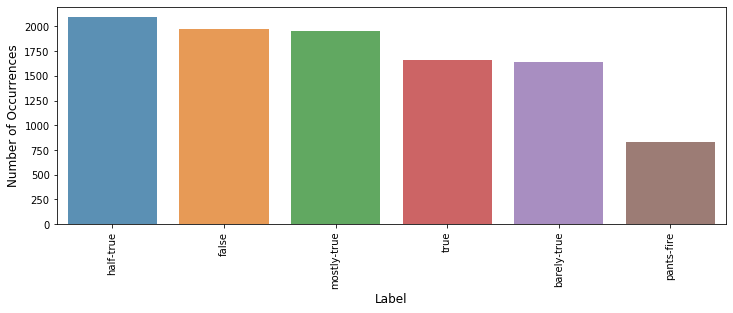

In [186]:
cnt_pro = df_train['label'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Label', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [187]:
train_processed_df = pd.DataFrame(train_processed_SJ)
train_processed_df.columns = ["SJ"]

test_processed_df = pd.DataFrame(test_processed_SJ)
test_processed_df.columns = ["SJ"]

val_processed_df = pd.DataFrame(val_processed_SJ)
val_processed_df.columns = ["SJ"]

In [194]:
# from bs4 import BeautifulSoup
# def cleanText(text):
#     text = BeautifulSoup(text, "lxml").text
#     text = re.sub(r'\|\|\|', r' ', text) 
#     text = re.sub(r'http\S+', r'<URL>', text)
#     text = text.lower()
#     text = text.replace('x', '')
#     return text

In [219]:
# df_train['statement'] = df_train['statement'].apply(cleanText)
df_train['statement'] = df_train['statement'].apply(preprocessing_pipeline)
df_train['statement'] = df_train['statement'].apply(nlp)
df_train['statement'] = df_train['statement'].apply(spacy_prepro)
df_train['statement'] = df_train['statement'].apply(' '.join)

# df_test['statement'] = df_test['statement'].apply(cleanText)
df_test['statement'] = df_test['statement'].apply(preprocessing_pipeline)
df_test['statement'] = df_test['statement'].apply(nlp)
df_test['statement'] = df_test['statement'].apply(spacy_prepro)
df_test['statement'] = df_test['statement'].apply(' '.join)

# df_val['statement'] = df_val['statement'].apply(cleanText)
df_val['statement'] = df_val['statement'].apply(preprocessing_pipeline)
df_val['statement'] = df_val['statement'].apply(nlp)
df_val['statement'] = df_val['statement'].apply(spacy_prepro)
df_val['statement'] = df_val['statement'].apply(' '.join)

In [196]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the complaint narrative.
    """
    labeled = []
    flag=0
    for i in range(len(corpus)):
        label = label_type + '_' + str(i)
        flag+=1
        labeled.append(doc2vec.TaggedDocument(corpus[i].split(), [label]))
    return labeled

In [227]:
# For S model
X_train = label_sentences(df_train['statement'],'Train')
# X_test = label_sentences(df_test['statement'],'Test')
X_test = label_sentences(df_val['statement'],'Test') # Validation Set
all_data = X_train + X_test

# ## For SJ model
# X_train = label_sentences(train_processed_df['SJ'],'Train')
# X_test = label_sentences(test_processed_df['SJ'],'Test')
# # X_test = label_sentences(val_processed_df['SJ'],'Test') # Validation Set
# all_data = X_train + X_test

# Distributed Bag of Words (DBOW) | Skip-Gram

In [228]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 11524/11524 [00:00<00:00, 2458678.43it/s]


In [229]:
%%time
flag=0
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    flag+=1
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha
    flag=0

100%|██████████| 11524/11524 [00:00<00:00, 1063948.04it/s]


CPU times: user 38.7 s, sys: 4.07 s, total: 42.8 s
Wall time: 28.8 s


In [223]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    flag=0
    for i in range(0, corpus_size):
        flag+=1
        prefix = vectors_type + '_' + str(i)
        check=flag
        vectors[i] = model.docvecs[prefix]
    return vectors

In [230]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [233]:
logreg =  LogisticRegression(random_state=0,solver='lbfgs',multi_class='multinomial').fit(train_vectors_dbow, train_blabels_df['label'])

/home/shreyash15097/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [237]:
predicted =logreg.predict(test_vectors_dbow)
print(classification_report(val_blabels_df['label'], predicted))
count=0
for i in range(len(val_blabels_df['label'])):
    if val_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

       false       0.68      0.93      0.79       867
        true       0.43      0.11      0.18       417

    accuracy                           0.66      1284
   macro avg       0.56      0.52      0.48      1284
weighted avg       0.60      0.66      0.59      1284

0.6635514018691588


# Plot

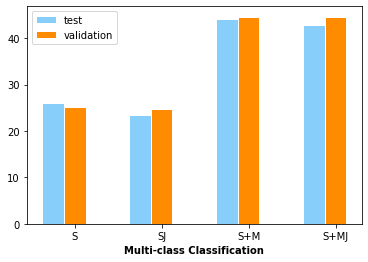

In [245]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = [25.93, 23.44, 44.04, 42.93]
bars2 = [25.23, 24.76, 44.62, 44.54]
# bars3 = [29, 3, 24, 25, 17]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
# r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='#87cefa', width=barWidth, edgecolor='white', label='test')
plt.bar(r2, bars2, color='#ff8c00', width=barWidth, edgecolor='white', label='validation')
# plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='var3')
 
# Add xticks on the middle of the group bars
plt.xlabel('Multi-class Classification', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['S', 'SJ', 'S+M', 'S+MJ'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

In [246]:
# Binary

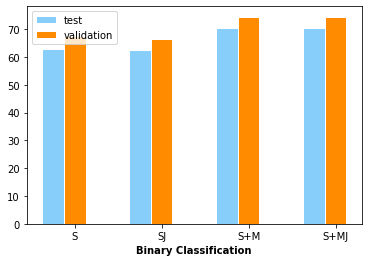

In [248]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = [62.98, 62.35, 70.48, 70.24]
bars2 = [67.60, 66.51, 74.22, 74.45]
# bars3 = [29, 3, 24, 25, 17]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
# r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='#87cefa', width=barWidth, edgecolor='white', label='test')
plt.bar(r2, bars2, color='#ff8c00', width=barWidth, edgecolor='white', label='validation')
# plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='var3')
 
# Add xticks on the middle of the group bars
plt.xlabel('Binary Classification', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['S', 'SJ', 'S+M', 'S+MJ'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

In [ ]:
# Doc2Vec train 

In [302]:
train_SJ_sent = []
for i in range(len(senti_train_df)):
    posval = senti_train_df['pos_sent'][i]
    negval = senti_train_df['neg_sent'][i]
    textval = train_processed_S[i]
    for j in range(int(posval)):
        textval+=' _pos_sent_'
    for j in range(int(negval)):
        textval+=' _neg_sent_'
    train_SJ_sent.append(textval)

In [303]:
train_SJ_sent_emo = []
for i in range(len(train_SJ_sent)):
    textval = train_SJ_sent[i]
    e1=emolex_train_df['e1'][i]
    e2=emolex_train_df['e2'][i]
    e3=emolex_train_df['e3'][i]
    e4=emolex_train_df['e4'][i]
    e5=emolex_train_df['e5'][i]
    e6=emolex_train_df['e6'][i]
    e7=emolex_train_df['e7'][i]
    e8=emolex_train_df['e8'][i]
    e9=emolex_train_df['e9'][i]
    e10=emolex_train_df['e10'][i]
    for j in range(int(e1)):
        textval+=' _e1_feat_'
    for j in range(int(e2)):
        textval+=' _e2_feat_'
    for j in range(int(e3)):
        textval+=' _e3_feat_'
    for j in range(int(e4)):
        textval+=' _e4_feat_'
    for j in range(int(e5)):
        textval+=' _e5_feat_'
    for j in range(int(e6)):
        textval+=' _e6_feat_'
    for j in range(int(e7)):
        textval+=' _e7_feat_'
    for j in range(int(e8)):
        textval+=' _e8_feat_'
    for j in range(int(e9)):
        textval+=' _e9_feat_'
    for j in range(int(e10)):
        textval+=' _e10_feat_'
    train_SJ_sent_emo.append(textval)

In [304]:
train_SJ_sent_emo_hist = []
for i in range(len(train_SJ_sent_emo)):
    textval = train_SJ_sent_emo[i]
    h1 = df['barely_true_count'][i]
    h2 = df['false_count'][i]
    h3 = df['half_true_count'][i]
    h4 = df['mostly_true_count'][i]
    h5 = df['pof_count'][i]
    for j in range(int(h1)):
        textval+=' _h1_feat_'
    for j in range(int(h2)):
        textval+=' _h2_feat_'
    for j in range(int(h3)):
        textval+=' _h3_feat_'
    for j in range(int(h4)):
        textval+=' _h4_feat_'
    for j in range(int(h5)):
        textval+=' _h5_feat_'
    train_SJ_sent_emo_hist.append(textval)

In [305]:
# Doc2vec test

In [306]:
test_SJ_sent = []
for i in range(len(senti_test_df)):
    posval = senti_test_df['pos_sent'][i]
    negval = senti_test_df['neg_sent'][i]
    textval = test_processed_S[i]
    for j in range(int(posval)):
        textval+=' _pos_sent_'
    for j in range(int(negval)):
        textval+=' _neg_sent_'
    test_SJ_sent.append(textval)

In [307]:
test_SJ_sent_emo = []
for i in range(len(test_SJ_sent)):
    textval = test_SJ_sent[i]
    e1=emolex_test_df['e1'][i]
    e2=emolex_test_df['e2'][i]
    e3=emolex_test_df['e3'][i]
    e4=emolex_test_df['e4'][i]
    e5=emolex_test_df['e5'][i]
    e6=emolex_test_df['e6'][i]
    e7=emolex_test_df['e7'][i]
    e8=emolex_test_df['e8'][i]
    e9=emolex_test_df['e9'][i]
    e10=emolex_test_df['e10'][i]
    for j in range(int(e1)):
        textval+=' _e1_feat_'
    for j in range(int(e2)):
        textval+=' _e2_feat_'
    for j in range(int(e3)):
        textval+=' _e3_feat_'
    for j in range(int(e4)):
        textval+=' _e4_feat_'
    for j in range(int(e5)):
        textval+=' _e5_feat_'
    for j in range(int(e6)):
        textval+=' _e6_feat_'
    for j in range(int(e7)):
        textval+=' _e7_feat_'
    for j in range(int(e8)):
        textval+=' _e8_feat_'
    for j in range(int(e9)):
        textval+=' _e9_feat_'
    for j in range(int(e10)):
        textval+=' _e10_feat_'
    test_SJ_sent_emo.append(textval)

In [308]:
test_SJ_sent_emo_hist = []
for i in range(len(test_SJ_sent_emo)):
    textval = test_SJ_sent_emo[i]
    h1 = df_test['barely_true_count'][i]
    h2 = df_test['false_count'][i]
    h3 = df_test['half_true_count'][i]
    h4 = df_test['mostly_true_count'][i]
    h5 = df_test['pof_count'][i]
    for j in range(int(h1)):
        textval+=' _h1_feat_'
    for j in range(int(h2)):
        textval+=' _h2_feat_'
    for j in range(int(h3)):
        textval+=' _h3_feat_'
    for j in range(int(h4)):
        textval+=' _h4_feat_'
    for j in range(int(h5)):
        textval+=' _h5_feat_'
    test_SJ_sent_emo_hist.append(textval)

In [309]:
# Doc2vec val set

In [310]:
val_SJ_sent = []
for i in range(len(senti_val_df)):
    posval = senti_val_df['pos_sent'][i]
    negval = senti_val_df['neg_sent'][i]
    textval = val_processed_S[i]
    for j in range(int(posval)):
        textval+=' _pos_sent_'
    for j in range(int(negval)):
        textval+=' _neg_sent_'
    val_SJ_sent.append(textval)

In [311]:
val_SJ_sent_emo = []
for i in range(len(val_SJ_sent)):
    textval = val_SJ_sent[i]
    e1=emolex_val_df['e1'][i]
    e2=emolex_val_df['e2'][i]
    e3=emolex_val_df['e3'][i]
    e4=emolex_val_df['e4'][i]
    e5=emolex_val_df['e5'][i]
    e6=emolex_val_df['e6'][i]
    e7=emolex_val_df['e7'][i]
    e8=emolex_val_df['e8'][i]
    e9=emolex_val_df['e9'][i]
    e10=emolex_val_df['e10'][i]
    for j in range(int(e1)):
        textval+=' _e1_feat_'
    for j in range(int(e2)):
        textval+=' _e2_feat_'
    for j in range(int(e3)):
        textval+=' _e3_feat_'
    for j in range(int(e4)):
        textval+=' _e4_feat_'
    for j in range(int(e5)):
        textval+=' _e5_feat_'
    for j in range(int(e6)):
        textval+=' _e6_feat_'
    for j in range(int(e7)):
        textval+=' _e7_feat_'
    for j in range(int(e8)):
        textval+=' _e8_feat_'
    for j in range(int(e9)):
        textval+=' _e9_feat_'
    for j in range(int(e10)):
        textval+=' _e10_feat_'
    val_SJ_sent_emo.append(textval)

In [312]:
val_SJ_sent_emo_hist = []
for i in range(len(val_SJ_sent_emo)):
    textval = val_SJ_sent_emo[i]
    h1 = df_val['barely_true_count'][i]
    h2 = df_val['false_count'][i]
    h3 = df_val['half_true_count'][i]
    h4 = df_val['mostly_true_count'][i]
    h5 = df_val['pof_count'][i]
    for j in range(int(h1)):
        textval+=' _h1_feat_'
    for j in range(int(h2)):
        textval+=' _h2_feat_'
    for j in range(int(h3)):
        textval+=' _h3_feat_'
    for j in range(int(h4)):
        textval+=' _h4_feat_'
    for j in range(int(h5)):
        textval+=' _h5_feat_'
    val_SJ_sent_emo_hist.append(textval)

In [313]:
train_processed_df = pd.DataFrame(train_SJ_sent_emo_hist)
train_processed_df.columns = ["SJ"]

test_processed_df = pd.DataFrame(test_SJ_sent_emo_hist)
test_processed_df.columns = ["SJ"]

val_processed_df = pd.DataFrame(val_SJ_sent_emo_hist)
val_processed_df.columns = ["SJ"]

In [322]:
X_train = label_sentences(train_processed_df['SJ'],'Train')
# X_test = label_sentences(test_processed_df['SJ'],'Test') # Test Set
X_test = label_sentences(val_processed_df['SJ'],'Test') # Validation Set
all_data = X_train + X_test

In [323]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 11524/11524 [00:00<00:00, 3335529.59it/s]


In [324]:
%%time
flag=0
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    flag+=1
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha
    flag=0

100%|██████████| 11524/11524 [00:00<00:00, 1201918.67it/s]


CPU times: user 54.4 s, sys: 4.39 s, total: 58.8 s
Wall time: 36.1 s


In [325]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [329]:
logreg =  LogisticRegression(random_state=0,solver='lbfgs',multi_class='multinomial').fit(train_vectors_dbow, train_blabels_df['label'])

/home/shreyash15097/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [330]:
predicted =logreg.predict(test_vectors_dbow)
print(classification_report(val_blabels_df['label'], predicted))
count=0
for i in range(len(val_blabels_df['label'])):
    if val_blabels_df['label'][i]==predicted[i]:
        count+=1
print(count/len(predicted))

              precision    recall  f1-score   support

       false       0.70      0.92      0.79       867
        true       0.51      0.17      0.25       417

    accuracy                           0.68      1284
   macro avg       0.60      0.55      0.52      1284
weighted avg       0.64      0.68      0.62      1284

0.677570093457944
